# Importing Libraries

In [1]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import torch
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric.nn as pyg_nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [2]:
torch.manual_seed(0)
random.seed(0)

# Loading the dataset

In [3]:
# 1. Load your CSV file into a pandas DataFrame
df = pd.read_csv(r"C:\Users\yomid\Downloads\Elasticity_Final_Report\Elasticity_Project_Pins\Data\new_merged_data.csv")

# Data Preprocessing

In [4]:
# 2. Extract Node Features (combine features for each node)
node_features = []
for index, row in df.iterrows():
    node_features.append([
        row['Soil Modulus (E_soil)'],     # E_soil
        row['Pressure at Node'],          # Pressure
        row['Spring Stiffness'],          # Spring Stiffness
        row['Pipe Burst Pressure'],       # Pipe Burst Pressure
        row['Temp'],                      # Temp
        row['Prev Temp'],                 # Prev Temp
        row['Displacement']               # Displacement
    ])

node_features = np.array(node_features)

# 3. Define Edges (Assume sequential connections for this example)
# Correct edge creation, ensuring last node (1055) is not out of bounds
edges = []
for i in range(len(df) - 1):  # len(df) - 1 prevents out-of-bounds errors
    edges.append([i, i + 1])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


# 4. Create Labels (1 for TRUE, 0 for FALSE)
labels = [1 if row['Burst Occurred'] else 0 for index, row in df.iterrows()]
labels = torch.tensor(labels, dtype=torch.float)

# 5. Convert Node Features to PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)

# 6. Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=labels)

# 7. Output the data object to verify
print(data)

Data(x=[1056, 7], edge_index=[2, 1055], y=[1056])


# Visualization

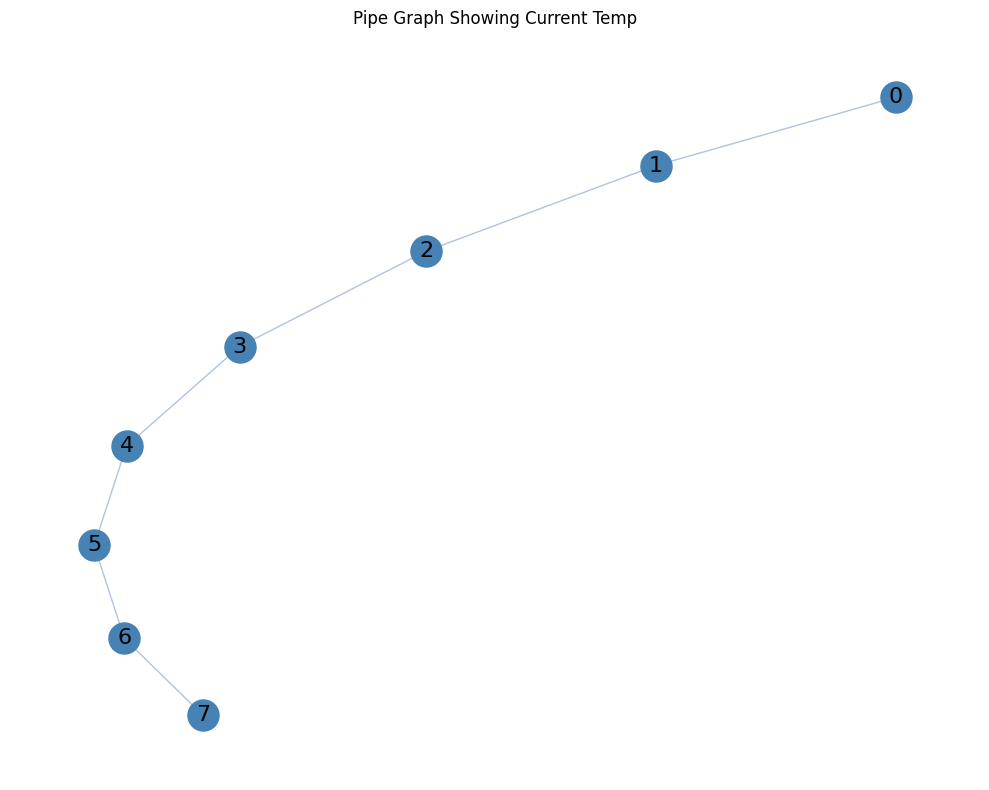

In [5]:
def visualize_graph(node_features, edge_index, temp_values, edge_attr=None):
    G = nx.Graph()
    for i, node_feature in enumerate(node_features):
        G.add_node(i, features=node_feature)
    
    num_edges = edge_index.size(1)
    for i in range(num_edges):
        source, target = edge_index[:, i].tolist()
        G.add_edge(source, target)

    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    node_labels = {i: f"{i}" for i in range(len(node_features))}
    
    # Use 'steelblue' for all nodes
    nx.draw(G, pos, ax=ax, with_labels=True, labels=node_labels, node_size=500, 
            node_color='steelblue', font_size=16, edge_color='lightsteelblue')

    plt.title("Pipe Graph Showing Current Temp")
    plt.savefig("Pipe_Graph_Temp.png", dpi=700)
    plt.tight_layout()
    plt.show()


# 9. Get the 'Temp' values for node coloring
temp_values = df['Temp'].tolist()

# 10. Ensure the same nodes are selected for edges
# For this pipe, select edges only involving the first 8 nodes
selected_edge_index = edge_index[:, :7]

# 11. Call the visualization function for the selected pipe
visualize_graph(node_features[:8], selected_edge_index, temp_values)

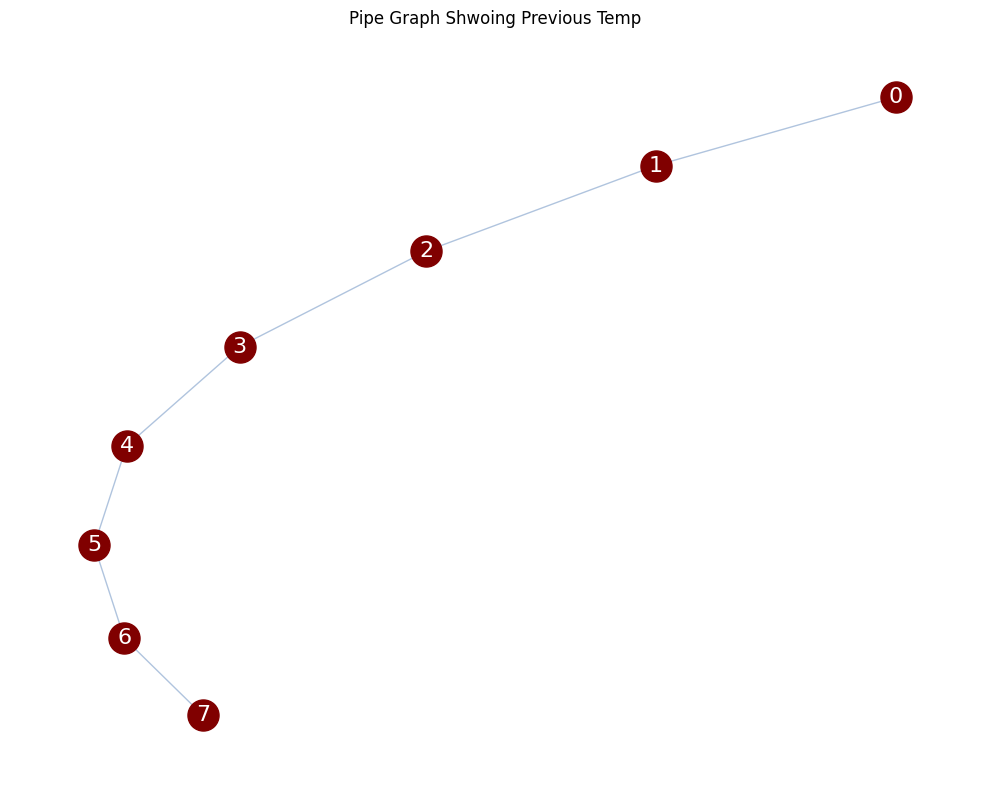

In [6]:
def visualize_graph(node_features, edge_index, temp_values, edge_attr=None):
    G = nx.Graph()
    for i, node_feature in enumerate(node_features):
        G.add_node(i, features=node_feature)
    
    num_edges = edge_index.size(1)
    for i in range(num_edges):
        source, target = edge_index[:, i].tolist()
        G.add_edge(source, target)

    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    node_labels = {i: f"{i}" for i in range(len(node_features))}
    
    # Use 'steelblue' for all nodes
    nx.draw(G, pos, ax=ax, with_labels=True, labels=node_labels, node_size=500, 
            node_color='maroon', font_size=16, font_color = "white",
            edge_color='lightsteelblue')

    plt.title("Pipe Graph Shwoing Previous Temp")
    plt.savefig("Pipe_Graph_Prev.png", dpi=700)
    plt.tight_layout()
    plt.show()


# 9. Get the 'Temp' values for node coloring
temp_values = df['Prev Temp'].tolist()

# 10. Ensure the same nodes are selected for edges
# For this pipe, select edges only involving the first 8 nodes
selected_edge_index = edge_index[:, :7]

# 11. Call the visualization function for the selected pipe
visualize_graph(node_features[:8], selected_edge_index, temp_values)

# Writng the torch Model

In [7]:
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 128)  
        self.conv2 = pyg_nn.GCNConv(128, 128)
        self.conv3 = pyg_nn.GCNConv(128, 64)  # Output size is now 64
        self.conv4 = pyg_nn.GCNConv(64, out_channels)

        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.batch_norm2 = torch.nn.BatchNorm1d(128)
        self.batch_norm3 = torch.nn.BatchNorm1d(64)

        self.dropout = 0.5
        
        # Linear transformation for adjusting dimensions
        self.linear_transform_1 = torch.nn.Linear(in_channels, 128)  # For conv1
        self.linear_transform_2 = torch.nn.Linear(128, 64)           # For conv3

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First convolution with residual connection
        x_res = self.linear_transform_1(x)  # Transforming x_res to match dimensions
        x = self.conv1(x, edge_index)
        x = F.relu(x + x_res)
        x = self.batch_norm1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second convolution
        x_res = x
        x = self.conv2(x, edge_index)
        x = F.relu(x + x_res)
        x = self.batch_norm2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Third convolution with adjusted residual connection
        x_res = self.linear_transform_2(x_res)  # Transforming for matching dimensions
        x = self.conv3(x, edge_index)
        x = F.relu(x + x_res)
        x = self.batch_norm3(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Fourth convolution layer (final prediction)
        x = self.conv4(x, edge_index)

        return x

In [8]:
# Instantiate the model
model = GNNModel(in_channels=7, out_channels=1)  # 7 input features, 1 output (binary classification)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss for binary classification

# Training loop with Early Stopping and Learning Rate Scheduler
num_epochs = 500
best_loss = float('inf')
patience = 10  # Early stopping patience
counter = 0
alpha = 1e-6
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [9]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    out = model(data)
    
    # Compute loss
    loss = loss_fn(out.squeeze(), data.y)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Step the scheduler
    scheduler.step()

    # Print the loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# After training, evaluate the model
model.eval()
with torch.no_grad():
    out = model(data)
    predictions = torch.sigmoid(out).squeeze()
    predicted_labels = (predictions > 0.5).float()
    
    # You can now compute accuracy and confusion matrix
    accuracy = (predicted_labels == data.y).sum().item() / len(data.y)
    print(f"Accuracy: {accuracy * 100:.2f}%")


Epoch 0, Loss: 0.7840233445167542
Epoch 10, Loss: 0.2831183075904846
Epoch 20, Loss: 0.20304416120052338
Epoch 30, Loss: 0.1464870125055313
Epoch 40, Loss: 0.11834199726581573
Epoch 50, Loss: 0.1169213056564331
Epoch 60, Loss: 0.11174563318490982
Epoch 70, Loss: 0.10401180386543274
Early stopping triggered!
Accuracy: 98.01%


In [12]:
print(f"Number of nodes: {x.shape[0]}")
print(f"Number of edges: {edge_index.shape[1]}")


Number of nodes: 1056
Number of edges: 1055


Accuracy: 96.12%
Precision: 95.65%
Recall: 98.74%
Specificity: 90.70%
F1-Score: 97.17%


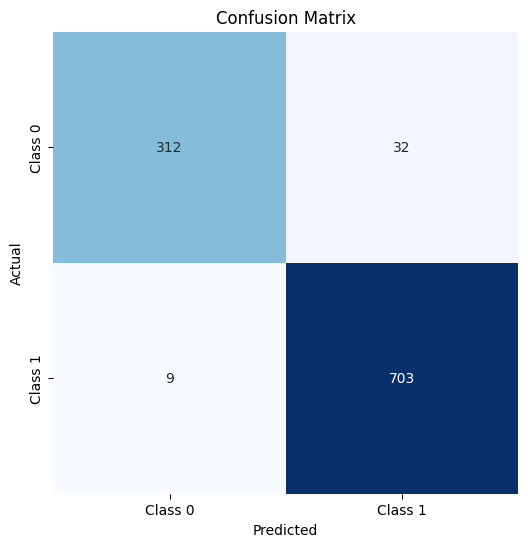

In [13]:
from sklearn import metrics

def evaluate_model(model, data):
    model.eval()  # Set model to evaluation mode

    # Forward pass (get predictions)
    with torch.no_grad():
        out = model(data)  # Logits from the model
        predictions = torch.sigmoid(out).squeeze()  # Apply sigmoid to get probabilities
        predicted_labels = (predictions > 0.3).float()  # Convert probabilities to binary predictions

    # Calculate accuracy
    accuracy = (predicted_labels == data.y).sum().item() / len(data.y)
    
    # Confusion Matrix
    cm = metrics.confusion_matrix(data.y.cpu(), predicted_labels.cpu())
    tn, fp, fn, tp = cm.ravel()  # Extract values from the confusion matrix

    # Calculate Precision, Recall, Specificity, and F1-Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, cm, precision, recall, specificity, f1_score

# Example usage
accuracy, cm, precision, recall, specificity, f1_score = evaluate_model(model, data)

# Print accuracy and metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")
print(f"F1-Score: {f1_score * 100:.2f}%")

# Plot confusion matrix
def plot_confusion_matrix(cm, labels=["Class 0", "Class 1"]):
    # Plot confusion matrix as a heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    plt.savefig("GNN_without_PL.png", dpi=700)
    plt.show()

# Call function to plot the confusion matrix
plot_confusion_matrix(cm)

# Single Prediction

In [25]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data

# Load your trained model
model.eval()  # Set the model to evaluation mode

# Load the CSV file
df = pd.read_csv(r"C:\Users\yomid\Downloads\Elasticity_Final_Report\Elasticity_Project_Pins\Data\new_merged_data.csv")

In [26]:
# Select the row (e.g., first row)
row = df.iloc[1000]

# Prepare node features
node_features = np.array([
    row['Soil Modulus (E_soil)'],  # E_soil
    row['Pressure at Node'],       # Pressure
    row['Spring Stiffness'],       # Spring Stiffness
    row['Pipe Burst Pressure'],    # Pipe Burst Pressure
    row['Temp'],                   # Temp
    row['Prev Temp'],              # Prev Temp
    row['Displacement']            # Displacement
])

# Convert to tensor and add batch dimension (unsqueeze)
x = torch.tensor(node_features, dtype=torch.float).unsqueeze(0)

# Add self-loop to edge_index for a single node
edge_index = torch.tensor([[0, 0]], dtype=torch.long).t().contiguous()  # A self-loop for a single node

# Create a dummy label for the Data object (can be any value as we only need x and edge_index)
y = torch.tensor([0], dtype=torch.float)

# Create the Data object for PyTorch Geometric
data = Data(x=x, edge_index=edge_index, y=y)

# Make prediction
with torch.no_grad():
    out = model(data)

# Apply sigmoid for probability
predictions = torch.sigmoid(out).squeeze()  # Remove batch dimension

# Convert to binary classification
predicted_label = (predictions > 0.3).float()  # 0 or 1

# Print result
print(f"Predicted Burst (0=No, 1=Yes): {predicted_label.item()}")

Predicted Burst (0=No, 1=Yes): 1.0
